In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rc_tools as rct
import rc_matrices as rcm
import rc_analysis as rca
import sys
import time

from sklearn.metrics import mean_squared_error
from scipy.special import kl_div
import pdb
import warnings
warnings.filterwarnings("ignore")
np.random.seed(11)
import scipy
import nolds

In [2]:
from scipy.signal import argrelmin, argrelmax

In [3]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

In [4]:
def NRMSE(target, pred,std):
    rmse = np.sqrt(mean_squared_error(target, pred))
    return rmse/std

def rank_along_trajectory(wr, wi, a, g, forcing, n, k, tolerance, delX):
    T = forcing.shape[0]
    ranks = np.zeros(T)
    conds = np.zeros(T)
    radii = np.zeros(T)
    uncertainty = np.zeros((n,T))
    def Func(x):
        return np.squeeze(-x.reshape(n,1) + (1-a)*x.reshape(n,1) +\
                          a*g*np.tanh(np.dot(wr,x.reshape(n,1)) +\
                         (np.dot(wi,ueq.reshape(k,1)).reshape(n,1))))
    for i in range(T):
        ueq = forcing[i]
        x0 = np.ones((n,1))*.5
        xeq = (fsolve(Func,x0)).reshape(n,1)
        A = rca.leaky_jacobian(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        radii[i] = np.max(np.abs(rca.eig_spectrum(A)))
        conds[i] = rca.condition_number(A)[0]
        B = rca.partial_u(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        uncertainty[:,i] = np.squeeze(np.dot(A,delX))
        Cplus = rca.controllability_matrix(A, B)
        ranks[i] = rca.rank(Cplus, tolerance)
        print(f'Time-step: {i} Rank: {ranks[i]} Uncertainty: {np.linalg.norm(uncertainty):.2f}  CondNum: {conds[i]:.2f}')
    return ranks, uncertainty, conds, radii



In [5]:
#import matplotlib as mpl
#mpl.font_manager._rebuild()
fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"


In [6]:
p = np.load('models_8_1/MG_32_InstanceParams.npy')
for i in range(p.shape[0]):
    print(f'{p[i]:.4f}')

0.3521
5.8157
0.2260
0.5799
3.6446
0.0021
0.3934
0.5418


Gradients [2.  1.5 1.5 2.  1.5 1.  1.  1.  1.5 1.5 1.  0.5 0.5 1.  1.  5.  5.  1.
 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
Tolerance 1e-15	 Rank 21
Tolerance 1e-16	 Rank 30
Ave 25.5


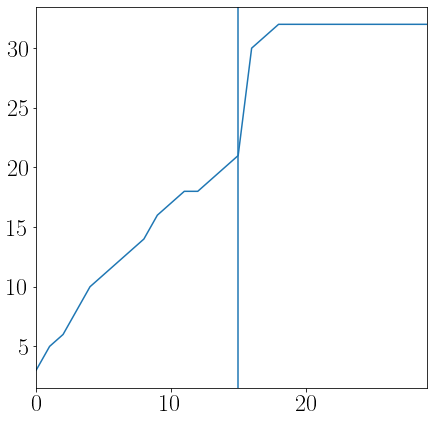

In [7]:
a = p[0]
g = p[2]
N = 32
K = 1
fname = 'models_8_1/MG_32_Wnet.npy'
Wr, Wi = rca.get_mats(fname, K,N)
x0 = np.zeros((N,1))
u0 = np.zeros((1,1))
A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
B = rca.partial_u(x0, u0, a, g, Wi, Wr)
Cn = rca.controllability_matrix(A,B)
Cn = Cn/np.max(np.abs(np.linalg.eigvals(Cn)))



rank_by_tol = []
tols = [1/10**x for x in range(0,30)]
for i in tols:
    rank_by_tol.append(rca.rank(Cn,i))

v = 15
print(f'Gradients {np.gradient(rank_by_tol)}')
print(f'Tolerance {tols[v]}\t Rank {rank_by_tol[v]}')
print(f'Tolerance {tols[v+1]}\t Rank {rank_by_tol[v+1]}')
print(f'Ave {(rank_by_tol[v]+rank_by_tol[v+1])/2}')
    
    
plt.figure(figsize=(7,7))
plt.plot(rank_by_tol[:])
plt.axvline(v)
plt.show()



In [8]:
p = np.load('Consistent/MG02_300_params.npy', allow_pickle=True)
p.shape

np.where(p[1,:].round(2)==5.39)

(array([96]),)

Gradients [ 1.   1.   0.5  1.   2.5  3.   2.5  2.5  2.5  2.   2.   2.   2.   3.
 19.  36.5 40.  40.5 40.  41.  35.5 16.5  2.5  0.5  0.   0.   0.   0.
  0.   0. ]
Tolerance 1e-13	 Rank 26
Tolerance 1e-14	 Rank 30
Ave 28.0


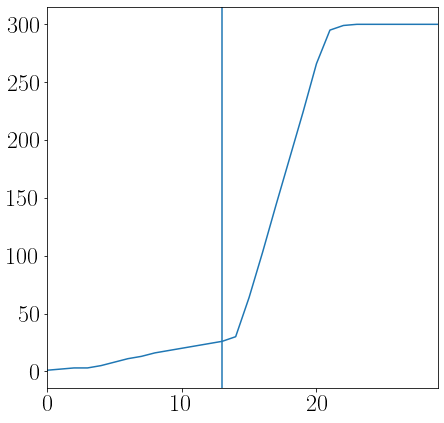

In [9]:
a = p[0,96]
g = p[2,96]
N = 300
K = 1
fname = 'Consistent/MG02_GPU_300_cossim.npy'
Wr, Wi = rca.get_mats(fname, K,N)
x0 = np.zeros((N,1))
u0 = np.zeros((1,1))
A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
B = rca.partial_u(x0, u0, a, g, Wi, Wr)
Cn = rca.controllability_matrix(A,B)
Cn = Cn/np.max(np.abs(np.linalg.eigvals(Cn)))

rank_by_tol = []
for i in tols:
    rank_by_tol.append(rca.rank(Cn,i))

v = 13
print(f'Gradients {np.gradient(rank_by_tol)}')
print(f'Tolerance {tols[v]}\t Rank {rank_by_tol[v]}')
print(f'Tolerance {tols[v+1]}\t Rank {rank_by_tol[v+1]}')
print(f'Ave {(rank_by_tol[v]+rank_by_tol[v+1])/2}')

plt.figure(figsize=(7,7))
plt.plot(rank_by_tol[:])
plt.axvline(v)
plt.show()



In [10]:

target = np.load('Consistent/MG_target_21000.npy')
#pred1000 = np.load('Loops/LoopData/MGStepTest1/hold2/MG_1000_preds.npy')      #('Consistent/MG02_predictions_GPU_1000.npy')
pred300 = np.load('Consistent/MG02_predictions_GPU_300.npy')
#pred225 = np.load('Loops/LoopData/MGStepTest/MG_225_preds.npy')
#pred100 = np.load('Consistent/MG02_predictions_GPU_100.npy')
pred32   = np.load('models_8_1/MG_32_preds.npy')
#pred50 = np.load('Consistent/MG02_predictions_GPU_50.npy')
#pred50 = np.load('Loops/LoopData/MGStepTest1/hold2/MG_50_preds.npy')

#pred35 = np.load('Consistent/MG02_predictions_GPU_35.npy')
#pred50 = np.load('Loops/LoopData/MGStepTest/MG_50_preds.npy')
#pred25 = np.load('Loops/LoopData/MGStepTest/MG_25_preds.npy')

In [11]:
minmax = np.max(target[:20000])-np.min(target[:20000])
NRMSE(target[19700:20000], pred32[19700:20000],minmax)

0.11529522059749515

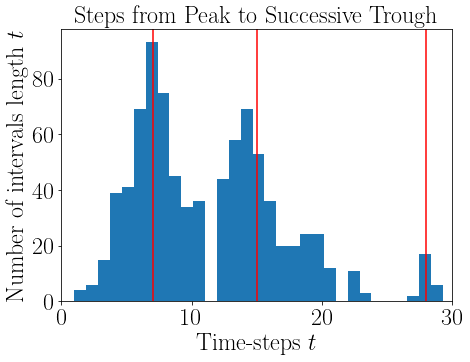

In [13]:
dists = argrelmax(target)[0]-argrelmin(target)[0][:-1]
fig = plt.figure(figsize=(7,5))
plt.hist(dists,80)
plt.axvline(7,c='r')
plt.axvline(15,c='r')
plt.axvline(28,c='r')
plt.xlim(0,30)
plt.title('Steps from Peak to Successive Trough')
plt.xlabel('Time-steps $t$')
plt.ylabel('Number of intervals length $t$')
plt.show()
fig.savefig("../ChaosPlots/MG_successive_steps.pdf", format='pdf', bbox_inches='tight', pad_inches=.01)

In [13]:
mn,mx = rca.support(pred32[:20000],pred32[:20000])
print(f'Support min={mn:.3f}\t max={mx:.3f}')
d = rca.distribution(target[19700:], pred32[19700:], -1, 1, 50)
d[0]

Support min=-695.596	 max=0.698


0.13869533570280873

In [14]:
target[19700:].max()

0.6416956635234299

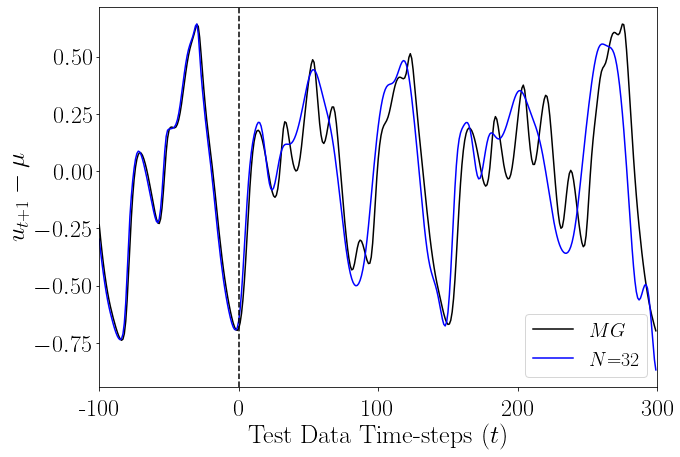

In [15]:
end=21000
plt.rcParams['xtick.major.pad']='8'
fig = plt.figure(figsize=(10,7))
plt.plot(target[end-1400:end-1000],'k', label=r'$MG$')
plt.plot(pred32[end-1400:end-1000],'b-', label='$N$=32')
plt.axvline(100, c='k',ls='dashed' )
plt.legend(loc='lower right',fontsize=20)
plt.xticks([0,100,200,300,400],[-100,0,100,200,300],  color='black', weight='heavy')
plt.yticks(c='black')
plt.xlabel('Test Data Time-steps '+'($t$)', fontsize=26, color='black', weight='heavy')
plt.ylabel(r'${u_{t+1} - \mu}$', fontsize=26, color='black', weight='heavy')
plt.show()

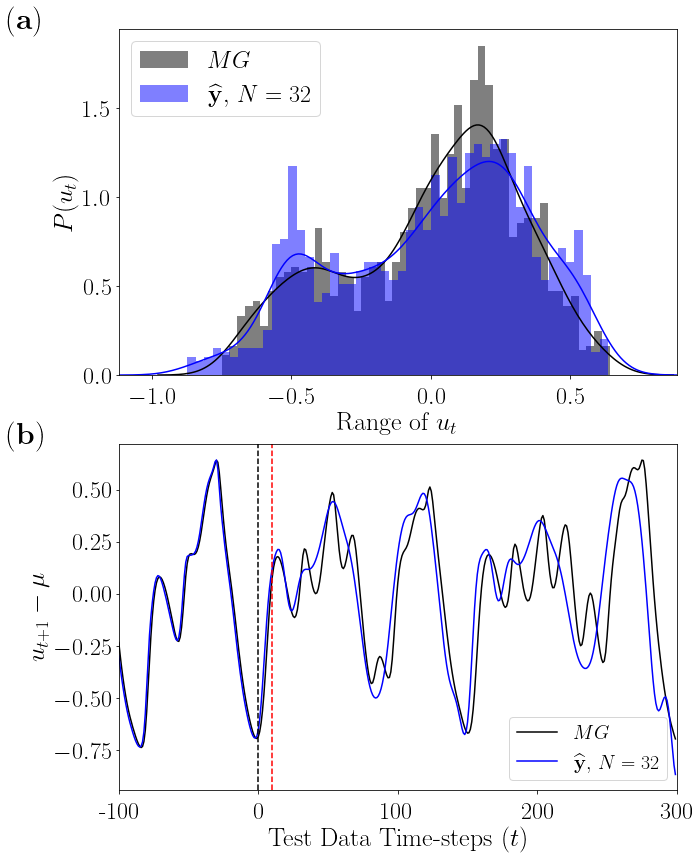

In [16]:
import seaborn as sns
import pandas as pd
fontsize = 24
n=32
data_dict = {'y': target[19700:],
             'yh': np.squeeze(pred32[19700:]),
            }
alpha = .5
bins = 50
df = pd.DataFrame(data=data_dict)


fig= plt.figure(figsize=(10,14))
ax1 = plt.subplot(211)
sns.distplot(df['y'],
             label='$MG$',
             bins=bins,
             color='k',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=.5))
sns.distplot(df['yh'],
             label='$\widehat{\mathbf{y}},\,N=32$',
             bins=bins,
             color='b',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=alpha))
plt.legend(loc='upper left', fontsize=fontsize)
plt.ylabel(r'${P}(u_t)$', fontsize=26,  color='black', weight='heavy')
plt.xlabel(r'Range of $u_t$', fontsize=26,  color='black', weight='heavy')
plt.xticks(c='black', fontsize=fontsize)
plt.yticks(c='black', fontsize=fontsize)
ax1.text(-0.2, 1.,s='$(\mathbf{a})$', transform=ax1.transAxes, 
            size=30, weight='bold')

ax2 = plt.subplot(212)
end=21000
plt.rcParams['xtick.major.pad']='8'
ax2.text(-0.2, 1.,s='$(\mathbf{b})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax2.plot(target[end-1400:end-1000],'k', label=r'$MG$')
ax2.plot(pred32[end-1400:end-1000],'b-', label='$\widehat{\mathbf{y}},\,N=32$')
ax2.axvline(100, c='k',ls='dashed' )
ax2.axvline(110, c='r',ls='dashed' )
ax2.legend(loc='lower right',fontsize=20)
ax2.set_xticks([0,100,200,300,400])
ax2.set_xticklabels([-100,0,100,200,300])
ax2.set_xlabel('Test Data Time-steps '+'($t$)', fontsize=26, color='black', weight='heavy')
ax2.set_ylabel(r'${u_{t+1} - \mu}$', fontsize=26, color='black', weight='heavy')

plt.show()
fig.savefig("../ChaosPlots/MG_combinedKL_Preds.pdf", format='pdf', bbox_inches='tight', pad_inches=.01)

k-size=5 Trainingset min=0.43335  threshold=0.41168  Location=69
k-size=10 Trainingset min=0.80111  threshold=0.76106  Location=20
k-size=20 Trainingset min=0.91038  threshold=0.86486  Location=20
k-size=32 Trainingset min=0.9244  threshold=0.87818  Location=10


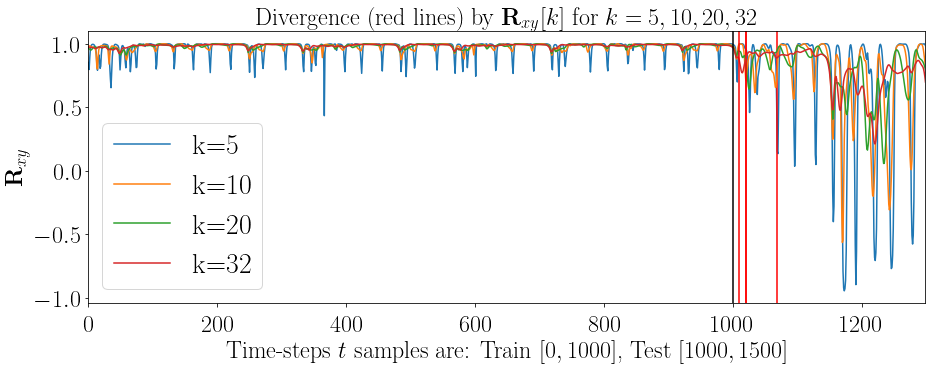

In [17]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))

k_list = [5,10,20,32]
start, stop = 18700, 20500  #Depends on dataset should be last 1000 train to 500 of free-run
plt.figure(figsize=(15,5))
for k in k_list:
    trainCorr = np.zeros((stop-start)-k)
    for j in range(start, stop-k):
        tar = target[j:j+k].reshape((k,1))
        prd = pred32[j:j+k].reshape((k,1))
        trainCorr[j-start] = Rxy(tar,prd)
    minVal = trainCorr[:1000].min()
    threshold = minVal-(minVal*.05)
    thresholdLoc = np.where(trainCorr[1000:1300]<threshold)[0][0]
    print(f'k-size={k} Trainingset min={trainCorr[:1000].min().round(5)}  threshold={threshold:.5f}',
          f' Location={thresholdLoc}')
    plt.plot(trainCorr[:1300], label=f'k={k}')
    plt.axvline(1000+thresholdLoc,color='r')
plt.ylabel('$\mathbf{R}_{xy}$')
plt.xlabel('Time-steps $t$ samples are: Train $[0,1000]$, Test $[1000,1500]$')
plt.legend(fontsize=28)
plt.axvline(1000,color='k') #End trainset
plt.title('Divergence (red lines) by $\mathbf{R}_{xy}[k]$ for $k=5,10,20,32$')
plt.show()

In [18]:
1.04**300

128825.48603032761